# Cost of Ransomware Recovery 

### AKA, why doesn’t everyone just pay?

Ransomeware is something that is in the headlines a lot, especially in recent months as attackers target municipalities. Some cities are paying the ransom, others are not. Atlanta refused to pay a ransom of $50,000 and wound up paying $2.6 million as a result to recover. Why is recovery so expensive?

In [2]:
import pandas as pd
import numpy as np

# for images
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# for scraping
import requests
from bs4 import BeautifulSoup


## Data Sources

* What Atlanta spent: https://procurement.atlantaga.gov/emergency-procurements/
* All Ransomware Attacks against cities https://go.recordedfuture.com/hubfs/reports/cta-2019-0510.pdf
* FBI Crime Report: https://pdf.ic3.gov/2018_IC3Report.pdf (32 crime types tracked. Interested in 12)
* CyberEdge Analysis of Worldwide Ransomware patterns https://www.imperva.com/resources/reports/CyberEdge-2019-CDR-Report-v1.1.pdf

### Get the data for all cities

Recorded Future analyzed all *known* ransomware attacks against cities and put them in a report, which I ran through tabula to generate the CSV file.

In [3]:
allcities = pd.read_csv("data/ransomware_report.csv", na_values=["Unknown"])
allcities.head(10)

,Date,City,State,Demand,Paid,Year
0,"Nov, 2013",Swansea PD,MA,$750,Y,2013
1,"Dec, 2013",Greenland,NH,$300,N,2013
2,"Jun, 2014",Durham PD,NH,NaN,N,2014
3,"Jun, 2014",Collinsville PD,AL,NaN,N,2014
4,"Nov, 2014",Dickson Sheriff Dept,TN,$572,Y,2014
5,"Feb, 2015",Midlothian PD,IL,$500,Y,2015
6,"Apr, 2015",Tewksbury,MA,$500,Y,2015
7,"Apr, 2015",Lincoln County Police,ME,$300,Y,2015
8,"Jan, 2016",Medfield,MA,$300,Y,2016
9,"Feb, 2016",Park County,WY,NaN,N,2016


In [4]:
# clean up fields
allcities['Date']= pd.to_datetime(allcities['Date']) 
allcities['Year']=pd.DatetimeIndex(allcities['Date']).year

allcities['Demand'] = allcities['Demand'].str.replace(',', '')
allcities['Demand'] = allcities['Demand'].str.replace('$', '')
allcities['Demand']=allcities['Demand'].astype(float)

# it doesn't make sense to have NaN in Demand if the city didn't pay in the first place. change to 0
allcities['Demand'].fillna(0,inplace=True)

allcities.head(10)

,Date,City,State,Demand,Paid,Year
0,2013-11-01,Swansea PD,MA,750.0,Y,2013
1,2013-12-01,Greenland,NH,300.0,N,2013
2,2014-06-01,Durham PD,NH,0.0,N,2014
3,2014-06-01,Collinsville PD,AL,0.0,N,2014
4,2014-11-01,Dickson Sheriff Dept,TN,572.0,Y,2014
5,2015-02-01,Midlothian PD,IL,500.0,Y,2015
6,2015-04-01,Tewksbury,MA,500.0,Y,2015
7,2015-04-01,Lincoln County Police,ME,300.0,Y,2015
8,2016-01-01,Medfield,MA,300.0,Y,2016
9,2016-02-01,Park County,WY,0.0,N,2016


In [5]:
#to make it easier, we drop all those where we don't know if it was paid or not
cities = allcities[(allcities['Paid']=='Y') | (allcities['Paid']=='N')]
cities.head(10)

,Date,City,State,Demand,Paid,Year
0,2013-11-01,Swansea PD,MA,750.0,Y,2013
1,2013-12-01,Greenland,NH,300.0,N,2013
2,2014-06-01,Durham PD,NH,0.0,N,2014
3,2014-06-01,Collinsville PD,AL,0.0,N,2014
4,2014-11-01,Dickson Sheriff Dept,TN,572.0,Y,2014
5,2015-02-01,Midlothian PD,IL,500.0,Y,2015
6,2015-04-01,Tewksbury,MA,500.0,Y,2015
7,2015-04-01,Lincoln County Police,ME,300.0,Y,2015
8,2016-01-01,Medfield,MA,300.0,Y,2016
9,2016-02-01,Park County,WY,0.0,N,2016


### Get the data from Atlanta

Atlanta posts its procurement requests online. I obtained the emergency procurements by Atlanta's IT department during the time period of interest

**The agency is not just Atlanta Information Management, so I visually checked, and then grabbed all in the relevant timeframe**

In [6]:
url = "https://procurement.atlantaga.gov/emergency-procurements/"
response = requests.get(url)
doc = BeautifulSoup(response.text)
rfps = doc.find_all('tbody')

#the first tbody is just the header info. all the data is in the second tbody
rfps[1]

<tbody><tr><td class="htCenter htMiddle" data-cell-id="A2" data-cell-type="text" data-db-index="2" data-order="3-22-18" data-original-value="3-22-18" data-x="0" data-y="2"> 3-22-18 </td><td class="htCenter htMiddle" data-cell-id="B2" data-cell-type="text" data-db-index="2" data-order="Atlanta Information Management" data-original-value="Atlanta Information Management" data-x="1" data-y="2"> Atlanta Information Management </td><td class="htCenter htMiddle" data-cell-id="C2" data-cell-type="text" data-db-index="2" data-order="C-1035" data-original-value="C-1035" data-x="2" data-y="2"> C-1035 </td><td class="htCenter htMiddle" data-cell-id="D2" data-cell-type="text" data-db-index="2" data-order="Cisco Security Incident Response Services" data-original-value="Cisco Security Incident Response Services" data-x="3" data-y="2"> Cisco Security Incident Response Services </td><td class="htCenter htMiddle" data-cell-id="E2" data-cell-type="text" data-db-index="2" data-order="CDW-G" data-original-

In [7]:
rows = []

#get the procurement requests 
for rfp in rfps[1]:
    row ={}
    try:
        row['date'] = rfp.find('td').text.strip()
    except:
        pass
    try:
        row['agency'] = rfp.find('td').next_sibling.text.strip()
    except:
        pass    
    try:
        row['description'] = rfp.find('td').next_sibling.next_sibling.next_sibling.text.strip()
    except:
        pass
    try:
        row['contractor'] = rfp.find('td').next_sibling.next_sibling.next_sibling.next_sibling.text.strip()
    except:
        pass
    try:
        row['amount'] = rfp.find('td').next_sibling.next_sibling.next_sibling.next_sibling.next_sibling.text.strip()
    except:
        pass
    rows.append(row)

atlanta = pd.DataFrame(rows)
atlanta

,agency,amount,contractor,date,description
0,Atlanta Information Management,"$60,000",CDW-G,3-22-18,Cisco Security Incident Response Services
1,Atlanta Information Management,"$60,000",Mosaic451,3-22-18,Surge Support Staff Augmentation
2,Atlanta Information Management,"$650,000",Secureworks,3-26-18,Emergency Incident Response Services
3,Department of Law,"$600,000","Ernst & Young, LLC",3-27-18,Advisory Services for Cyber Incident Response
4,Municipal Courts,"$730,000",Fyrsoft,3-29-18,"Microsoft Cloud, Client Stack Design and Build..."
5,Department of Law,"$50,000",Edelman,3-29-18,Crisis Communications Services
6,Municipal Courts,"$124,000",Pioneer Technology Group,3-29-18,Development and Deployment of Benchmark
7,Atlanta Information Management,"$393,328","Airnet Gorup, Inc.",4-2-18,"Microsoft Azure Cloud Engineering, Development..."
8,Atlanta Information Management,"$376,240",CDW Government,4-18-18,Forescout CounterACT System
9,Atlanta Information Management,"$66,000",Turnkey Solutions,4-23-18,IT Subject Matter Expert Consulting Services


In [8]:
# I care only about procurement requests in March and April
atlanta['date']= pd.to_datetime(atlanta['date']) 
atlanta = atlanta[(atlanta['date'] > '03-01-2018') & (atlanta['date'] < '05-01-2018')]

atlanta

,agency,amount,contractor,date,description
0,Atlanta Information Management,"$60,000",CDW-G,2018-03-22,Cisco Security Incident Response Services
1,Atlanta Information Management,"$60,000",Mosaic451,2018-03-22,Surge Support Staff Augmentation
2,Atlanta Information Management,"$650,000",Secureworks,2018-03-26,Emergency Incident Response Services
3,Department of Law,"$600,000","Ernst & Young, LLC",2018-03-27,Advisory Services for Cyber Incident Response
4,Municipal Courts,"$730,000",Fyrsoft,2018-03-29,"Microsoft Cloud, Client Stack Design and Build..."
5,Department of Law,"$50,000",Edelman,2018-03-29,Crisis Communications Services
6,Municipal Courts,"$124,000",Pioneer Technology Group,2018-03-29,Development and Deployment of Benchmark
7,Atlanta Information Management,"$393,328","Airnet Gorup, Inc.",2018-04-02,"Microsoft Azure Cloud Engineering, Development..."
8,Atlanta Information Management,"$376,240",CDW Government,2018-04-18,Forescout CounterACT System
9,Atlanta Information Management,"$66,000",Turnkey Solutions,2018-04-23,IT Subject Matter Expert Consulting Services


In [9]:
#fix amount fields
atlanta['amount'] = atlanta['amount'].str.replace(',', '')
atlanta['amount'] = atlanta['amount'].str.replace('$', '')
atlanta['amount'] = atlanta['amount'].astype(float)

atlanta

/home/fahmida/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/fahmida/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fahmida/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,agency,amount,contractor,date,description
0,Atlanta Information Management,60000.00,CDW-G,2018-03-22,Cisco Security Incident Response Services
1,Atlanta Information Management,60000.00,Mosaic451,2018-03-22,Surge Support Staff Augmentation
2,Atlanta Information Management,650000.00,Secureworks,2018-03-26,Emergency Incident Response Services
3,Department of Law,600000.00,"Ernst & Young, LLC",2018-03-27,Advisory Services for Cyber Incident Response
4,Municipal Courts,730000.00,Fyrsoft,2018-03-29,"Microsoft Cloud, Client Stack Design and Build..."
5,Department of Law,50000.00,Edelman,2018-03-29,Crisis Communications Services
6,Municipal Courts,124000.00,Pioneer Technology Group,2018-03-29,Development and Deployment of Benchmark
7,Atlanta Information Management,393328.00,"Airnet Gorup, Inc.",2018-04-02,"Microsoft Azure Cloud Engineering, Development..."
8,Atlanta Information Management,376240.00,CDW Government,2018-04-18,Forescout CounterACT System
9,Atlanta Information Management,66000.00,Turnkey Solutions,2018-04-23,IT Subject Matter Expert Consulting Services


In [10]:
# create categories
atlanta['purpose'] = np.where(atlanta.description.str.contains('Incident Response'), 'IR',
                               np.where(atlanta.description.str.contains('Surge Support'), "Staff",
                               np.where(atlanta.description.str.contains('Communications'), "PR",
                               np.where(atlanta.description.str.contains('Consulting'), "Consulting",
                               np.where(atlanta.description.str.contains('Technicians'), "Support",
                               np.where(atlanta.description.str.contains('Support Staff'), "Support",
                               np.where(atlanta.description.str.contains('Microsoft'), "Infrastructure",
                               np.where(atlanta.description.str.contains('Duo'), "Security",
                               np.where(atlanta.description.str.contains('Forescout'), "Security",
                               np.where(atlanta.description.str.contains('ForeScout'), "Security",
                               np.where(atlanta.description.str.contains('SMARTNet'), "Support",
                               np.where(atlanta.description.str.contains('Waste'), "Waste",
                               np.where(atlanta.description.str.contains('Benchmark'), "Infrastructure","no")))))))))))))

atlanta

/home/fahmida/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,agency,amount,contractor,date,description,purpose
0,Atlanta Information Management,60000.00,CDW-G,2018-03-22,Cisco Security Incident Response Services,IR
1,Atlanta Information Management,60000.00,Mosaic451,2018-03-22,Surge Support Staff Augmentation,Staff
2,Atlanta Information Management,650000.00,Secureworks,2018-03-26,Emergency Incident Response Services,IR
3,Department of Law,600000.00,"Ernst & Young, LLC",2018-03-27,Advisory Services for Cyber Incident Response,IR
4,Municipal Courts,730000.00,Fyrsoft,2018-03-29,"Microsoft Cloud, Client Stack Design and Build...",Infrastructure
5,Department of Law,50000.00,Edelman,2018-03-29,Crisis Communications Services,PR
6,Municipal Courts,124000.00,Pioneer Technology Group,2018-03-29,Development and Deployment of Benchmark,Infrastructure
7,Atlanta Information Management,393328.00,"Airnet Gorup, Inc.",2018-04-02,"Microsoft Azure Cloud Engineering, Development...",Infrastructure
8,Atlanta Information Management,376240.00,CDW Government,2018-04-18,Forescout CounterACT System,Security
9,Atlanta Information Management,66000.00,Turnkey Solutions,2018-04-23,IT Subject Matter Expert Consulting Services,Consulting


### Get the payments data

Manually create the dataframe

In [59]:
status = pd.DataFrame({"pay": ['N', 'N', 'Y','Y'], 
                       "data":['N','Y','Y','N'],
                       "total": [123, 517, 321,203]})
#No and lost, 123,2019
#No and okay, 517,2019
#Yes and okay,321,2019
#Yes and lost,203,2019
status

,pay,data,total
0,N,N,123
1,N,Y,517
2,Y,Y,321
3,Y,N,203


### Word Analysis

Get the list of all affected services

In [12]:
services = pd.read_csv("data/services.csv", na_values=["Unknown"])
services = services.reset_index()
services = services.drop(['index','words', 'empty'], axis=1)
services.head(10)

,me
0,emails
1,arrests
2,crime
3,credit card processing
4,court
5,311
6,building permits
7,building inspection
8,payroll
9,billing


In [314]:
services.me.value_counts().sort_values(by=['total'], ascending=True)
#.plot(kind='barh', figsize=(20,10))

TypeError: sort_values() got an unexpected keyword argument 'by'

## Analyzing the Data

In [13]:
allcities.Year.value_counts()

2018    54
2016    47
2019    41
2017    39
2015     3
2014     3
2013     2
Name: Year, dtype: int64

In [14]:
# majority have not paid
allcities.Paid.value_counts()

N    121
U     36
Y     32
Name: Paid, dtype: int64

In [15]:
# majority have not paid
cities.Paid.value_counts()

N    121
Y     32
Name: Paid, dtype: int64

In [16]:
#who paid and who didn't pay, by year
allcities.groupby(['Year']).Paid.value_counts()

Year  Paid
2013  N        1
      Y        1
2014  N        2
      Y        1
2015  Y        3
2016  N       35
      Y        9
      U        3
2017  N       27
      U        6
      Y        6
2018  N       40
      U        7
      Y        7
2019  U       20
      N       16
      Y        5
Name: Paid, dtype: int64

In [17]:
#who paid and who didn't pay, by year
cities.groupby(['Year']).Paid.value_counts()

Year  Paid
2013  N        1
      Y        1
2014  N        2
      Y        1
2015  Y        3
2016  N       35
      Y        9
2017  N       27
      Y        6
2018  N       40
      Y        7
2019  N       16
      Y        5
Name: Paid, dtype: int64

In [40]:
#average ransom paid
paid = cities[(cities['Paid']=='Y')]
paid.groupby(['Year']).Demand.mean()

Year
2013       750.000000
2014       572.000000
2015       433.333333
2016      9563.555556
2017      7511.666667
2018      7500.000000
2019    318000.000000
Name: Demand, dtype: float64

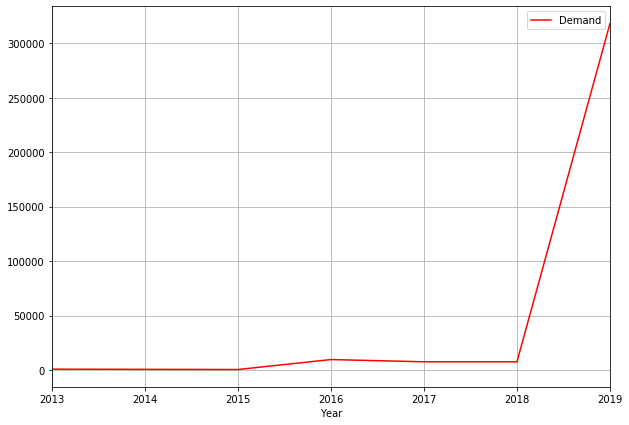

In [56]:
#this is a scary line, but it is misleading
paidchart = pd.DataFrame(paid.groupby(['Year']).Demand.mean())
paidchart = paidchart.reset_index()
paidchart.plot(x='Year',y='Demand', figsize=(10,7), color="red")
plt.grid()
plt.savefig("data/output/median-2019.pdf", transparent=True)

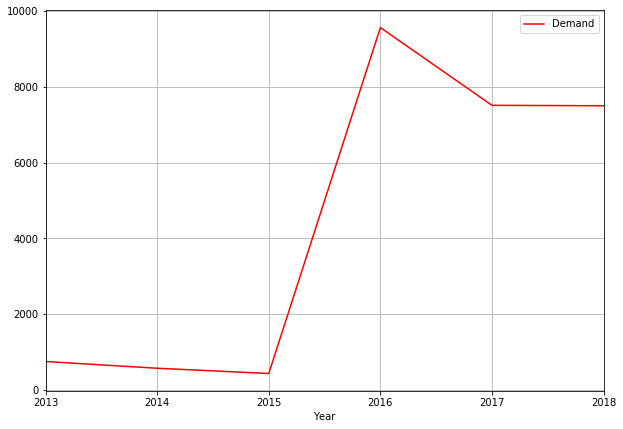

In [57]:
#this is a better line, but it misses 2019
no2019 = pd.DataFrame(paid.groupby(['Year']).Demand.mean())
no2019 = no2019.reset_index()
no2019 = no2019[(no2019['Year']!=2019)]
no2019.plot(x='Year',y='Demand', figsize=(10,7), color="red")
plt.grid()
plt.savefig("data/output/medians.pdf", transparent=True)

In [41]:
#average ransom paid
paid.groupby(['Date']).Demand.mean()

Date
2013-11-01       750.0
2014-11-01       572.0
2015-02-01       500.0
2015-04-01       400.0
2016-01-01       300.0
2016-02-01       489.0
2016-04-01     25000.0
2016-06-01      2883.0
2016-11-01     21000.0
2016-12-01      9100.0
2017-02-01         0.0
2017-04-01     30000.0
2017-07-01      1000.0
2017-08-01      2900.0
2017-10-01      9170.0
2017-12-01      2000.0
2018-02-01         0.0
2018-03-01      8000.0
2018-04-01     10000.0
2018-07-01     16250.0
2018-10-01      2000.0
2018-11-01         0.0
2019-03-01    400000.0
2019-04-01         0.0
2019-06-01    530000.0
2019-07-01    130000.0
Name: Demand, dtype: float64

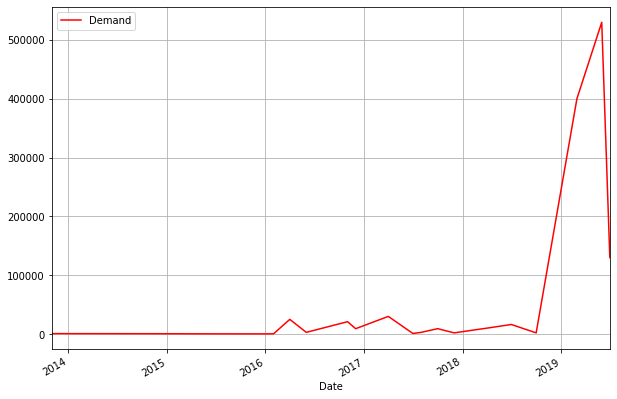

In [54]:
#average ransom paid
Dated = pd.DataFrame(paid.groupby(['Date']).Demand.mean())
Dated = Dated.reset_index() 
Dated = Dated[(Dated.Demand!=0)]
Dated.plot(x='Date',y='Demand', figsize=(10,7), color="red")
plt.grid()
plt.savefig("data/output/mean.pdf", transparent=True)

<Figure size 1440x720 with 0 Axes>

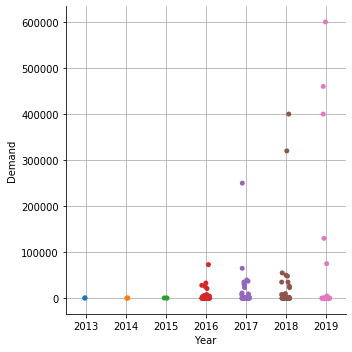

In [55]:
plt.figure(figsize=(20, 10))
sns.catplot(x="Year", y="Demand", data=cities)
plt.grid()
plt.savefig("data/output/ransoms.pdf", transparent=True)

Create a bar chart showing what Atlanta spent its money on

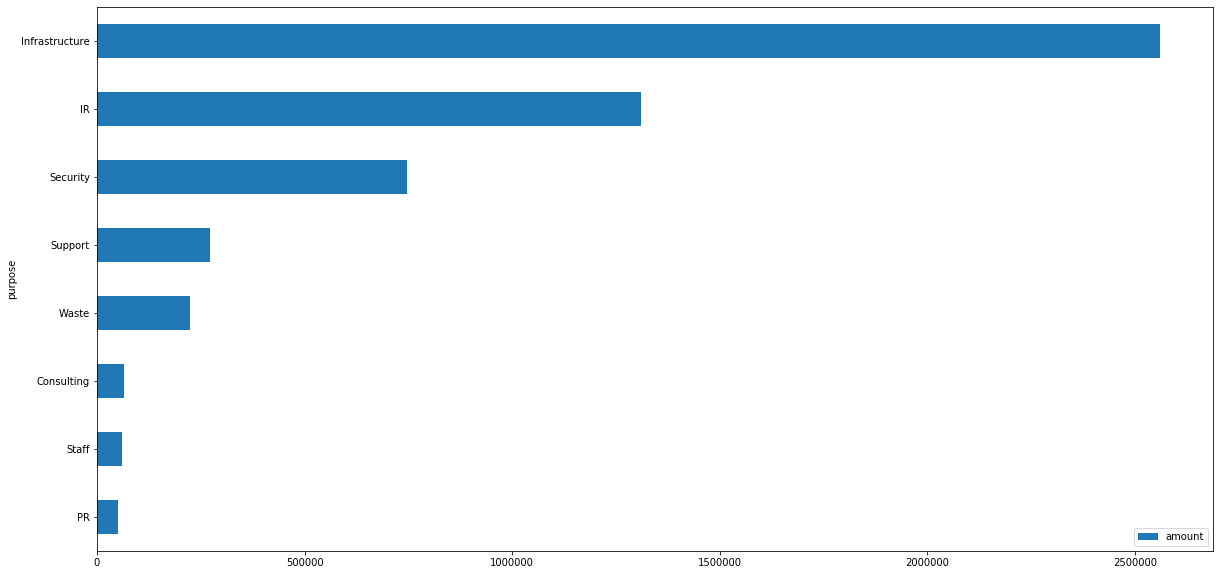

In [44]:
atlanta.groupby(['purpose']).sum().sort_values(by=['amount'], ascending=True).plot(kind='barh', figsize=(20,10))
plt.savefig("data/output/atlanta.pdf", transparent=True)

In [67]:
## Did not pay: What happened to my data?
notpay = status[status['pay']=='N']
notpay = notpay.drop('pay',axis=1)
notpay
# i did not pay. 517 got their data back, 123 did not.

,data,total
0,N,123
1,Y,517


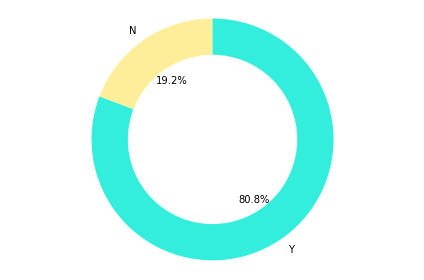

<Figure size 432x288 with 0 Axes>

In [72]:
colors = ['#ffee99','#33eedd']
 
fig1, ax1 = plt.subplots()
ax1.pie(notpay.total, colors = colors, labels=notpay.data, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

plt.savefig("data/output/didnotpay.pdf", transparent=True)

In [70]:
## Paid: What happened to my data?
ransom = status[status['pay']=='Y']
ransom = ransom.drop('pay', axis=1)
ransom
#i paid. 321 got their data back, 203 did not.

,data,total
2,Y,321
3,N,203


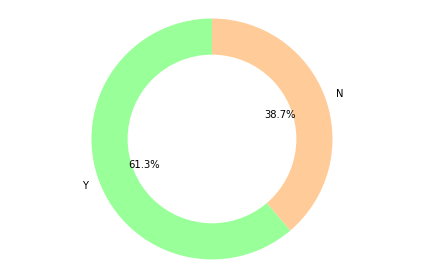

<Figure size 432x288 with 0 Axes>

In [73]:
colors = ['#99ff99','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(ransom.total, colors = colors, labels=ransom.data, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

plt.savefig("data/output/paynotpay.pdf", transparent=True)

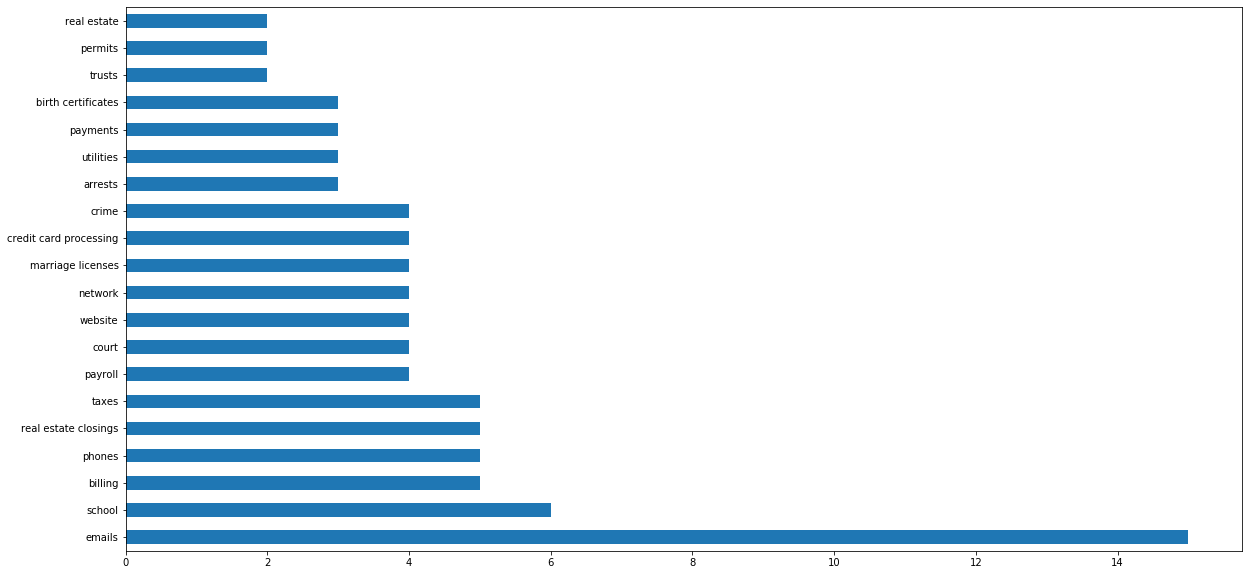

In [50]:
services.me.value_counts().head(20).plot(kind='barh', figsize=(20,10))
plt.savefig("data/output/services.pdf", transparent=True)